In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 读取数据
data = pd.read_csv('../input/merged_data_ALL3.csv')

# 特征和目标列
features = ['001_SS_Close', '399_SZ_Close', 'HIS_Close', 'IXIC_Close', 'FTSE_Close', 'JM0_Close']
target = '600_Close'

X = data[features]
y = data[target]

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 1. Lasso回归 (使用sklearn)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

# 2. 弹性网回归 (使用sklearn)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
elastic_net_pred = elastic_net.predict(X_test)

# 3. XGBoost回归 (使用xgboost)
xgboost = XGBRegressor()
xgboost.fit(X_train, y_train)
xgboost_pred = xgboost.predict(X_test)

# 4. RNN回归 (使用PyTorch)
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

rnn_model = RNNModel(input_size=X_train.shape[1], hidden_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

for epoch in range(50):
    for inputs, targets in train_loader:
        inputs = inputs.view(-1, 1, X_train.shape[1])
        outputs = rnn_model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

X_test_rnn = X_test_tensor.view(-1, 1, X_test.shape[1])
rnn_pred = rnn_model(X_test_rnn).detach().numpy()

# 5. LSTM回归 (使用PyTorch)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

lstm_model = LSTMModel(input_size=X_train.shape[1], hidden_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

for epoch in range(50):
    for inputs, targets in train_loader:
        inputs = inputs.view(-1, 1, X_train.shape[1])
        outputs = lstm_model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

X_test_lstm = X_test_tensor.view(-1, 1, X_test.shape[1])
lstm_pred = lstm_model(X_test_lstm).detach().numpy()

# 打印结果
print("Lasso回归预测:", lasso_pred)
print("弹性网回归预测:", elastic_net_pred)
print("XGBoost回归预测:", xgboost_pred)
print("RNN回归预测:", rnn_pred)
print("LSTM回归预测:", lstm_pred)


Lasso回归预测: [7.67707339 9.64850985 6.99945543 7.18761415 8.79983091 7.12553718
 9.41588054 8.88352021 7.29192257 7.10070745 8.44090048 7.32482721
 7.70095167 7.79721832 7.5021381  7.32533348 7.70012486 7.17665766
 7.80641482 7.29477716 7.7114097  7.66485967 8.33954583 9.73767614
 7.16960792 7.67030514 7.66515711 8.43249762 9.55541264 8.98555987
 7.02932962 9.73674474 7.39942433 7.4660299  7.45998841 9.70598621
 9.59250828 7.26583903 7.85163471 8.30909521 8.07932005 9.85689491
 7.28957562 7.78942835 7.24859806 7.44484901 8.69406326 9.48276099
 9.14527571 7.77394595 7.11706089 7.59988084 7.77608629 8.49133941
 8.22120414 6.94922101 9.4934816  7.45203888 8.72617507 6.97646465
 8.96761959 8.60591583 7.8030531  8.75374116 9.0002051  8.44654915
 7.28397278 7.62465949 8.13929897 7.85006775 7.66531488 7.74309173]
弹性网回归预测: [ 7.68361738  9.75665161  6.97927735  7.1263674   8.88734957  7.06519985
  9.5473527   8.98187486  7.20680198  7.05444353  8.37720677  7.31409222
  7.76893932  7.81552585  7.4

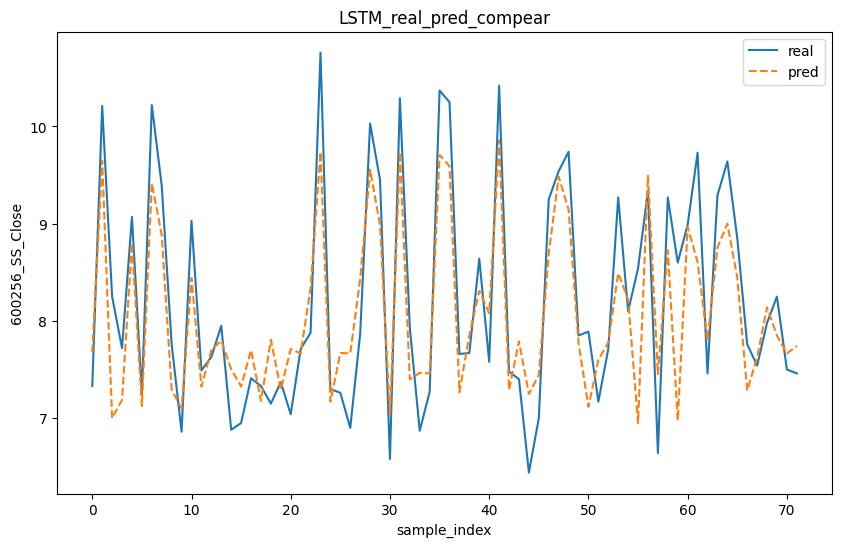

In [6]:
import matplotlib.pyplot as plt
# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='real')
plt.plot(lasso_pred, label='pred', linestyle='--')
plt.legend()
plt.title('LSTM_real_pred_compear')
plt.xlabel('sample_index')
plt.ylabel('600256_SS_Close')
plt.show()